# Simple ballistics demo
Mike Hansen, March 2019

The purpose of this demo is to illustrate the ODE solvers in Spitfire with adaptive time stepping and a custom termination rule.

Also: to show the modularity and how a "single step" method can be used in your own time loop.

In [1]:
def right_hand_side(q, fluid_density, drag_coeff, gravity, surface_area, mass):
    """
    Computes the right-hand side function for the ODE system.

    Note that time integration requires a function that takes (t, y) as arguments.
    To accomodate this, we will write a lambda after defining the rate constants,
    which passes the appropriate y value and rate constant to this function (and ignores the time).

    :param q: current vector of velocities and positions
    :param fluid_density: fluid density
    :param drag_coeff: drag coefficient of the flying object
    :param gravity: gravitational constant
    :param surface_area: surface area of the flying object
    :param mass: mass of the flying object
    :return: right-hand side of the ODE system
    """
    vel_x = q[0]
    vel_y = q[1]
    f = fluid_density * surface_area * drag_coeff / mass
    return np.array([-f * vel_x * vel_x,
                     -f * vel_y * vel_y - gravity,
                     vel_x,
                     vel_y])


In [13]:
import numpy as np

q0 = np.array([1., 10., 0., 0.])     # initial condition (vx, vy, x, y)

rf = 1.23                            # fluid density, kg/m3
ro = 7.86e3                          # object (cannonball) density, kg/m3
g = 9.8                              # gravitational constant, m/s2
r = 4. * 2.54 / 100.                 # object radius, m
sa = 4. * np.pi * r * r              # surface area, m2
m = ro * np.pi * r * r * r * 4. / 3. # mass, kg

In [14]:
drag_coeff_dict = {'no drag': 0.0, 'weak drag': 4.0, 'strong drag': 40.0}

In [15]:
from spitfire.time.governor import Governor, FinalTime, SaveAllDataToList
from spitfire.time.stepcontrol import PIController
from spitfire.time.methods import AdaptiveERK54CashKarp

<IPython.core.display.Javascript object>


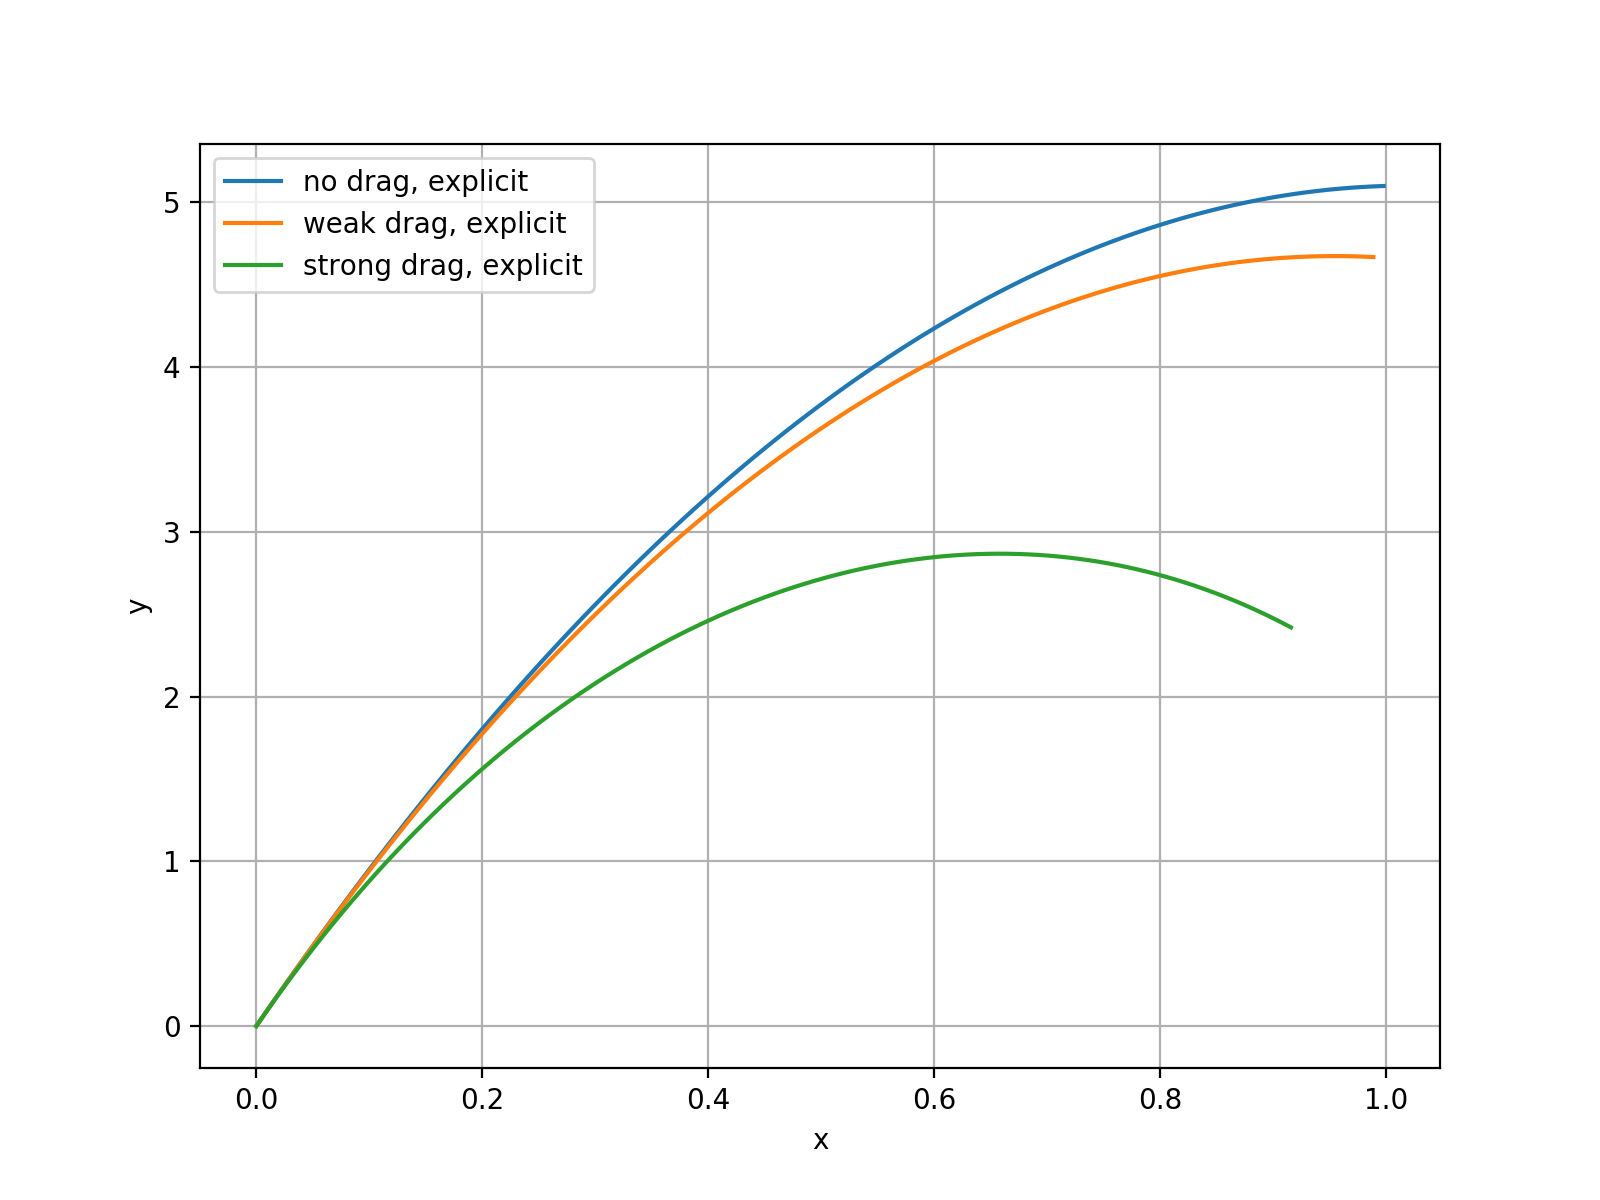

In [16]:
governor = Governor()
governor.termination_criteria = FinalTime(1.)
governor.do_logging = False

%matplotlib notebook
import matplotlib.pyplot as plt

for key in drag_coeff_dict:
    cd = drag_coeff_dict[key]
    
    data = SaveAllDataToList(initial_solution=q0, save_frequency=10)
    governor.custom_post_process_step = data.save_data

    governor.integrate(right_hand_side=lambda t, y: right_hand_side(y, rf, cd, g, sa, m),
                       initial_condition=q0,
                       controller=PIController(),
                       method=AdaptiveERK54CashKarp())
    
    plt.plot(data.solution_list[:, 2], data.solution_list[:, 3], label=key + ', explicit')

plt.grid()
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.gcf().set_size_inches(8, 6)
plt.show()

In [17]:
from spitfire.time.governor import CustomTermination

def object_has_landed(state, *args, **kwargs):
    """
    Enables us to integrate until the object has landed

    :param state: the state vector for time integration
    :param args: additional positional arguments
    :param kwargs: additional keyword arguments
    :return: True if the object has not yet landed
    """
    vel_y = state[1]
    pos_y = state[3]
    return not (pos_y < 0.5 * r and vel_y < 0)

governor = Governor()
governor.do_logging = False
governor.termination_criteria = CustomTermination(object_has_landed)

<IPython.core.display.Javascript object>


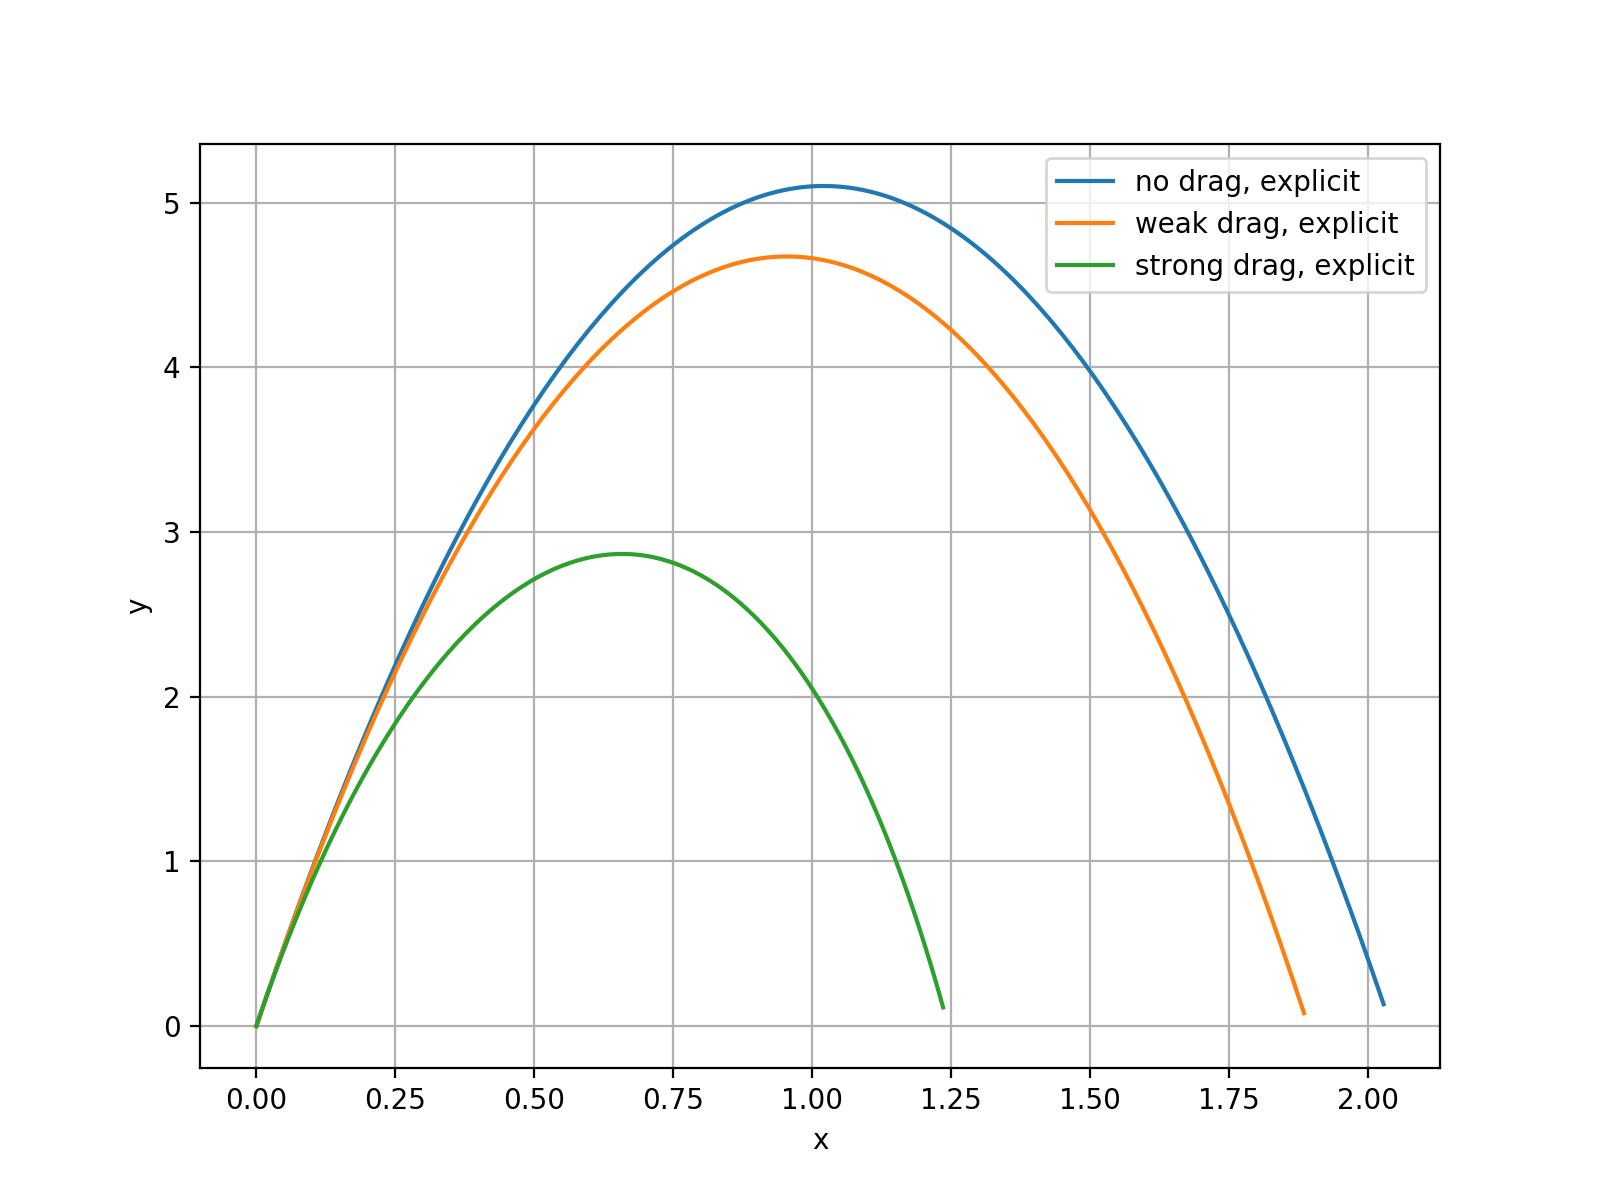

In [18]:
%matplotlib notebook

for key in drag_coeff_dict:
    cd = drag_coeff_dict[key]
    
    data = SaveAllDataToList(initial_solution=q0, save_frequency=10)
    governor.custom_post_process_step = data.save_data

    governor.integrate(right_hand_side=lambda t, y: right_hand_side(y, rf, cd, g, sa, m),
                       initial_condition=q0,
                       controller=PIController(),
                       method=AdaptiveERK54CashKarp())
    
    plt.plot(data.solution_list[:, 2], data.solution_list[:, 3], label=key + ', explicit')

plt.grid()
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.gcf().set_size_inches(8, 6)
plt.show()

<IPython.core.display.Javascript object>


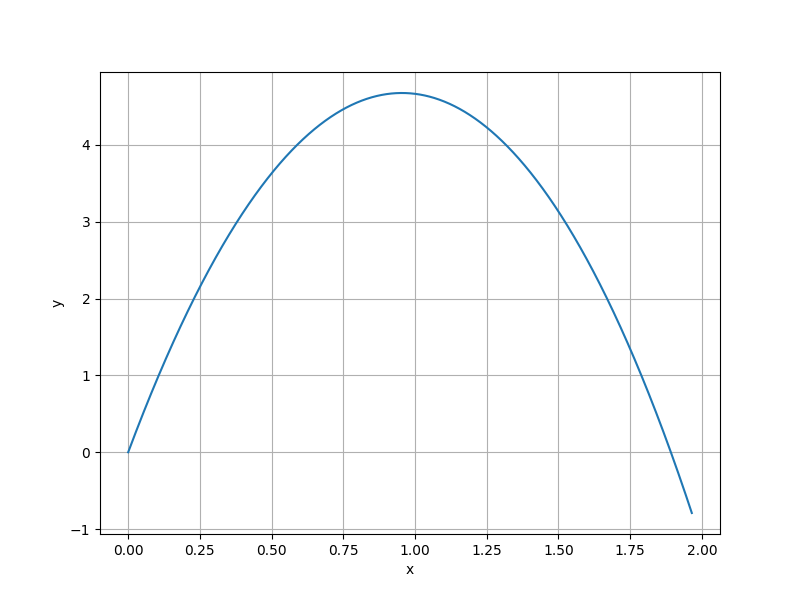

In [11]:
from spitfire.time.methods import ExplicitRungeKutta4Classical as RK4
%matplotlib notebook

rhs = lambda t, y: right_hand_side(y, rf, drag_coeff_dict['weak drag'], g, sa, m)

q_list = [q0]
q = np.copy(q0)

t = 0
dt = 0.001

while t < 2.0:
    q += RK4().single_step(q, t, dt, rhs).solution_update
    q_list.append(np.copy(q))
    t += dt

q_list = np.array(q_list)

x = q_list[:, 2]
y = q_list[:, 3]

plt.plot(x, y)

plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.gcf().set_size_inches(8, 6)
plt.show()